## Embeddings for Weather Data

An embedding is a low-dimensional, vector representation of a (typically) high-dimensional feature which maintains the semantic meaning of the feature in a such a way that similar features are close in the embedding space.

In this notebook, we use autoencoders to create embeddings for HRRR images. We can then use the embeddings to search for "similar" weather patterns.

In [2]:
!apt-get -y install libeccodes0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libaec0 libeccodes-data libgfortran4 libopenjp2-7
The following NEW packages will be installed:
  libaec0 libeccodes-data libeccodes0 libgfortran4 libopenjp2-7
0 upgraded, 5 newly installed, 0 to remove and 48 not upgraded.
Need to get 3516 kB of archives.
After this operation, 68.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libaec0 amd64 0.3.2-2 [18.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libeccodes-data all 2.6.0-2 [1260 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgfortran4 amd64 7.5.0-3ubuntu1~18.04 [492 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libopenjp2-7 amd64 2.3.0-2build0.18.04.1 [145 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libeccodes0 amd64 2.6.0-2 [1601 kB]
F

In [3]:
%pip install -q cfgrib xarray

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Reading HRRR data and converting to TensorFlow Records

HRRR data comes in a Grib2 files on Cloud Storage.

In [1]:
!gsutil ls -l gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.*.wrfsfcf00*

 105624174  2020-08-11T00:51:01Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t00z.wrfsfcf00.grib2
      7842  2020-08-11T00:50:39Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t00z.wrfsfcf00.grib2.idx
 104905515  2020-08-11T01:49:31Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t01z.wrfsfcf00.grib2
      7842  2020-08-11T01:49:04Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t01z.wrfsfcf00.grib2.idx
 101942347  2020-08-11T02:48:01Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t02z.wrfsfcf00.grib2
      7840  2020-08-11T02:47:33Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t02z.wrfsfcf00.grib2.idx
 101412287  2020-08-11T03:52:23Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t03z.wrfsfcf00.grib2
      7839  2020-08-11T03:51:52Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t03z.wrfsfcf00.grib2.idx
 101204218  2020-08-11T04:50:36Z  gs://high-resolution-rapid-ref

In [5]:
FILENAME="gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t18z.wrfsfcf06.grib2"   # derecho in the Midwest
!gsutil ls -l {FILENAME}

 128701013  2020-08-11T19:02:22Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t18z.wrfsfcf06.grib2
TOTAL: 1 objects, 128701013 bytes (122.74 MiB)


In [3]:
import xarray as xr
import tensorflow as tf
import tempfile
import cfgrib

with tempfile.TemporaryDirectory() as tmpdirname:
    TMPFILE="{}/read_grib".format(tmpdirname)
    tf.io.gfile.copy(FILENAME, TMPFILE, overwrite=True)
    ds = cfgrib.open_datasets(TMPFILE)
    print(ds)

[<xarray.Dataset>
Dimensions:                (x: 1799, y: 1059)
Coordinates:
    time                   datetime64[ns] 2020-08-11T18:00:00
    step                   timedelta64[ns] 06:00:00
    adiabaticCondensation  int64 0
    latitude               (y, x) float64 ...
    longitude              (y, x) float64 ...
    valid_time             datetime64[ns] ...
Dimensions without coordinates: x, y
Data variables:
    gh                     (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP , <xarray.Dataset>
Dimensions:     (x: 1799, y: 1059)
Coordinates:
    time        datetime64[ns] 2020-08-11T18:00:00
    step        timedelta64[ns] 06:00:00
    atmosphere  int64 0
    latitude    (y, x) float64 21.14 21.15 21.15 21.16 ... 47.86 47.85 47.84
    

We have to choose one of the following:
```
    filter_by_keys={'typeOfLevel': 'unknown'}
    filter_by_keys={'typeOfLevel': 'cloudTop'}
    filter_by_keys={'typeOfLevel': 'surface'}
    filter_by_keys={'typeOfLevel': 'heightAboveGround'}
    filter_by_keys={'typeOfLevel': 'isothermal'}
    filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
    filter_by_keys={'typeOfLevel': 'pressureFromGroundLayer'}
    filter_by_keys={'typeOfLevel': 'sigmaLayer'}
    filter_by_keys={'typeOfLevel': 'meanSea'}
    filter_by_keys={'typeOfLevel': 'heightAboveGroundLayer'}
    filter_by_keys={'typeOfLevel': 'sigma'}
    filter_by_keys={'typeOfLevel': 'depthBelowLand'}
    filter_by_keys={'typeOfLevel': 'isobaricLayer'}
    filter_by_keys={'typeOfLevel': 'cloudBase'}
    filter_by_keys={'typeOfLevel': 'nominalTop'}
    filter_by_keys={'typeOfLevel': 'isothermZero'}
    filter_by_keys={'typeOfLevel': 'adiabaticCondensation'}
```

[1059 1799]


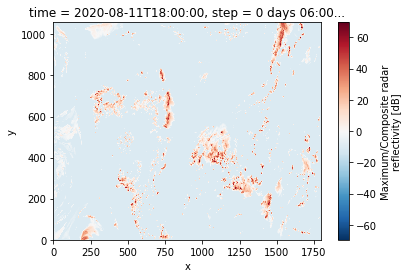

In [23]:
import xarray as xr
import tensorflow as tf
import tempfile
import cfgrib
import numpy as np

with tempfile.TemporaryDirectory() as tmpdirname:
    TMPFILE="{}/read_grib".format(tmpdirname)
    tf.io.gfile.copy(FILENAME, TMPFILE, overwrite=True)
    #ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface', 'stepType': 'instant'}})
    #ds.data_vars['prate'].plot()  # crain, prate
    #ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'unknown', 'stepType': 'instant'}})
    ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'atmosphere', 'stepType': 'instant'}})
    ds.data_vars['refc'].plot()
    print(np.array([ds.data_vars['refc'].sizes['y'], ds.data_vars['refc'].sizes['x']]))

In [24]:
import numpy as np

def _array_feature(value, min_value, max_value):
    """Wrapper for inserting ndarray float features into Example proto."""
    value = np.nan_to_num(value.flatten()) # nan, -inf, +inf to numbers
    value = np.clip(value, min_value, max_value) # clip to valid
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def create_tfrecord(filename):
    with tempfile.TemporaryDirectory() as tmpdirname:
        TMPFILE="{}/read_grib".format(tmpdirname)
        tf.io.gfile.copy(filename, TMPFILE, overwrite=True)
        ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'atmosphere', 'stepType': 'instant'}})
   
        # create a TF Record with the raw data
        tfexample = tf.train.Example(
            features=tf.train.Features(
                feature={
                    'ref': _array_feature(ds.data_vars['refc'].data, min_value=0, max_value=60),
        }))
        return tfexample.SerializeToString()

s = create_tfrecord(FILENAME)
print(len(s), s[:16])

7620594 b'\n\xed\x8f\xd1\x03\n\xe8\x8f\xd1\x03\n\x03ref\x12'


In [25]:
from datetime import datetime, timedelta
def generate_filenames(startdate: str, enddate: str):
    start_dt = datetime.strptime(startdate, '%Y%m%d')
    end_dt = datetime.strptime(enddate, '%Y%m%d')
    dt = start_dt
    while dt <= end_dt:
        # gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t04z.wrfsfcf00.grib2
        f = '{}/hrrr.{:4}{:02}{:02}/conus/hrrr.t{:02}z.wrfsfcf00.grib2'.format(
                'gs://high-resolution-rapid-refresh',
                dt.year, dt.month, dt.day, dt.hour)
        dt = dt + timedelta(hours=1)
        yield f
print([x for x in generate_filenames('20190915', '20190917')])

['gs://high-resolution-rapid-refresh/hrrr.20190915/conus/hrrr.t00z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190915/conus/hrrr.t01z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190915/conus/hrrr.t02z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190915/conus/hrrr.t03z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190915/conus/hrrr.t04z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190915/conus/hrrr.t05z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190915/conus/hrrr.t06z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190915/conus/hrrr.t07z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190915/conus/hrrr.t08z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190915/conus/hrrr.t09z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190915/conus/hrrr.t10z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190915/conus/hrrr.t11z.wrfsfcf00

## Write a Beam pipeline

In [26]:
%%writefile wxsearch/hrrr_to_tfrecord.py

import os
import xarray as xr
import tensorflow as tf
import tempfile
import cfgrib
from datetime import datetime, timedelta
import numpy as np
import argparse
import logging
import shutil
import subprocess
import apache_beam as beam
import random

def _array_feature(value, min_value, max_value):
    if isinstance(value, type(tf.constant(0))): # if value is tensor
        value = value.numpy() # get value of tensor
 
    """Wrapper for inserting ndarray float features into Example proto."""
    value = np.nan_to_num(value.flatten()) # nan, -inf, +inf to numbers
    value = np.clip(value, min_value, max_value) # clip to valid
    print(value[:10])
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def create_tfrecord(filename):
    print(filename)
    with tempfile.TemporaryDirectory() as tmpdirname:
        TMPFILE="{}/read_grib".format(tmpdirname)
        tf.io.gfile.copy(filename, TMPFILE, overwrite=True)
        ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'atmosphere', 'stepType': 'instant'}})
   
        # create a TF Record with the raw data
        refc = ds.data_vars['refc']
        size = np.array([ds.data_vars['refc'].sizes['y']*1.0, ds.data_vars['refc'].sizes['x']*1.0])
        tfexample = tf.train.Example(
            features=tf.train.Features(
                feature={
                    'size': tf.train.Feature(float_list=tf.train.FloatList(value=size)),
                    #'ref': _array_feature(refc.data, min_value=0, max_value=60),
        }))
        return tfexample.SerializeToString()

def generate_filenames(startdate: str, enddate: str):
    start_dt = datetime.strptime(startdate, '%Y%m%d')
    end_dt = datetime.strptime(enddate, '%Y%m%d')
    print('Hourly records from {} to {}'.format(start_dt, end_dt))
    dt = start_dt
    while dt < end_dt:
        # gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t04z.wrfsfcf00.grib2
        f = '{}/hrrr.{:4}{:02}{:02}/conus/hrrr.t{:02}z.wrfsfcf00.grib2'.format(
                'gs://high-resolution-rapid-refresh',
                dt.year, dt.month, dt.day, dt.hour)
        dt = dt + timedelta(hours=1)
        yield f

def run_job(options):
    # start the pipeline
    opts = beam.pipeline.PipelineOptions(flags=[], **options)
    with beam.Pipeline(options['runner'], options=opts) as p:
        # create examples
        examples = (
          p
          | 'hrrr_files' >> beam.Create(
              generate_filenames(options['startdate'], options['enddate']))
          | 'create_tfr' >>
          beam.FlatMap(lambda x: create_tfrecord(x))
        )

        # shuffle the examples so that each small batch doesn't contain
        # highly correlated records
        #examples = (examples
        #      | 'reshuffleA' >> beam.Map(
        #          lambda t: (random.randint(1, 1000), t))
        #      | 'reshuffleB' >> beam.GroupByKey()
        #      | 'reshuffleC' >> beam.FlatMap(lambda t: t[1]))

        # write out tfrecords
        _ = (examples
              | 'write_tfr' >> beam.io.tfrecordio.WriteToTFRecord(
                  os.path.join(options['outdir'], 'tfrecord')))


if __name__ == '__main__':
    parser = argparse.ArgumentParser(
      description='Create training/eval files for lightning prediction')
    parser.add_argument(
      '--project',
      default='',
      help='Specify GCP project to bill to run on cloud')
    parser.add_argument(
      '--outdir', required=True, help='output dir. could be local or on GCS')
  
    parser.add_argument(
      '--startdate',
      type=str,
      required=True,
      help='eg 20200915')
    parser.add_argument(
      '--enddate',
      type=str,
      required=True,
      help='eg 20200916 -- this is exclusive')
    
    
    # parse command-line args and add a few more
    logging.basicConfig(level=getattr(logging, 'INFO', None))
    options = parser.parse_args().__dict__
    outdir = options['outdir']
    options.update({
      'staging_location':
          os.path.join(outdir, 'tmp', 'staging'),
      'temp_location':
          os.path.join(outdir, 'tmp'),
      'job_name':
          'wxsearch-' + datetime.now().strftime('%y%m%d-%H%M%S'),
      'teardown_policy':
          'TEARDOWN_ALWAYS',
      'max_num_workers':
          20,
      'machine_type':
          'n1-standard-8',
      'region':
          'us-central1',
      'setup_file':
          os.path.join(os.path.dirname(os.path.abspath(__file__)), './setup.py'),
      'save_main_session':
          True,
      # 'sdk_location':
      #    './local/beam/sdks/python/dist/apache-beam-2.12.0.tar.gz'
    })

    if not options['project']:
        print('Launching local job ... hang on')
        shutil.rmtree(outdir, ignore_errors=True)
        os.makedirs(outdir)
        options['runner'] = 'DirectRunner'
    else:
        print('Launching Dataflow job {} ... hang on'.format(options['job_name']))
        try:
            subprocess.check_call('gsutil -m rm -r {}'.format(outdir).split())
        except:  # pylint: disable=bare-except
            pass
        options['runner'] = 'DataflowRunner'

    run_job(options)

Overwriting wxsearch/hrrr_to_tfrecord.py


In [2]:
%%writefile wxsearch/repro.py

import os
import tensorflow as tf
from datetime import datetime, timedelta
import numpy as np
import argparse
import logging
import shutil
import subprocess
import apache_beam as beam
import random


def create_tfrecord2(x):
    size = np.array([1024.0, 640.0])
    tfexample = tf.train.Example(
            features=tf.train.Features(
                feature={
                    'size': tf.train.Feature(float_list=tf.train.FloatList(value=size)),
    }))
    return tfexample.SerializeToString()


def run_job(options):
    # start the pipeline
    opts = beam.pipeline.PipelineOptions(flags=[], **options)
    with beam.Pipeline(options['runner'], options=opts) as p:
        # create examples
        examples = (
          p
          | 'hrrr_files' >> beam.Create([1,2,3])
          | 'create_tfr' >> beam.FlatMap(lambda x: create_tfrecord2(x))
        )

        # write out tfrecords
        _ = (examples
              | 'write_tfr' >> beam.io.tfrecordio.WriteToTFRecord(
                  os.path.join(options['outdir'], 'tfrecord')))


if __name__ == '__main__':
    parser = argparse.ArgumentParser(
      description='Repro TFX error')
    parser.add_argument(
      '--outdir', required=True, help='output dir. could be local or on GCS')

    # parse command-line args and add a few more
    logging.basicConfig(level=getattr(logging, 'INFO', None))
    options = parser.parse_args().__dict__
    outdir = options['outdir']
    options.update({
      'staging_location':
          os.path.join(outdir, 'tmp', 'staging'),
      'temp_location':
          os.path.join(outdir, 'tmp'),
      'job_name':
          'wxsearch-' + datetime.now().strftime('%y%m%d-%H%M%S'),
      'teardown_policy':
          'TEARDOWN_ALWAYS',
      'max_num_workers':
          20,
      'machine_type':
          'n1-standard-8',
      'region':
          'us-central1',
      'save_main_session':
          True,
    })

    print('Launching local job ... hang on')
    shutil.rmtree(outdir, ignore_errors=True)
    os.makedirs(outdir)
    options['runner'] = 'DirectRunner'

    run_job(options)

Overwriting wxsearch/repro.py


In [1]:
%run -m wxsearch.repro -- --outdir tmp 
# --startdate 20190915 --enddate 20190916 --project ai-analytics-solutions --outdir gs://ai-analytics-solutions-kfpdemo/wxsearch

Launching local job ... hang on


INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function annotate_downstream_side_inputs at 0x7fabc682f680> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function fix_side_input_pcoll_coders at 0x7fabc682f7a0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function pack_combiners at 0x7fabc682f830> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function lift_combiners at 0x7fabc682f8c0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_sdf at 0x7fabc682f950> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_gbk at 0x7fabc682f9e0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==============

RuntimeError: AssertionError: (10, <class 'int'>) [while running 'write_tfr/Write/WriteImpl/WriteBundles']

/root/apache-beam-custom/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2848: UserWarning: Unknown failure executing module: <wxsearch.repro>
  warn('Unknown failure executing module: <%s>' % mod_name)


Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License